#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 12
### Due: Monday, Apr 25th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on Apr 25th.

**This is your last homework assignment.**

---

## Problem 1

**Density Estimation and Clustering**

Fill in the blanks below and answer all questions. This exercise will take you though some topics from this and last week.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import homogeneity_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


Setup up the data set. We will do both density estimation and clustering on it.

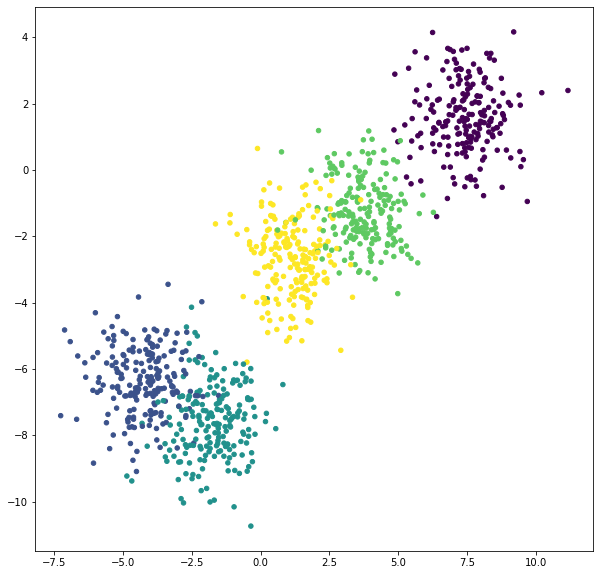

In [2]:
from sklearn.datasets import make_blobs
#Make two blobs with 3 features and 1000 samples
N=1000
X,y = make_blobs(n_samples=N, centers=5, n_features=2, random_state=25)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=20, c=y)


Start with kernel density estimation, including a grid search to find the best bandwidth.

0.4724137931034482


/Users/katiecella/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


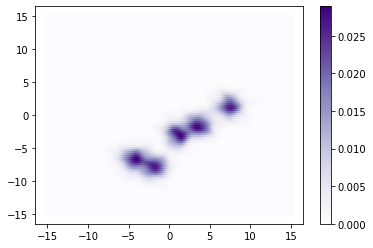

In [3]:
bwrange = np.linspace(0.1,1.0,30) # Test 30 bandwidths from 0.1 to 1.0 ####
K = 5 # 5-fold cross validation ####  
# Note: this is actually be the default, so it K = None, it would do the same thing
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) ####
grid.fit(X) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth'] ####
print(h_opt)

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-15,15,100)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens, cmap="Purples", edgecolor="None") ####
plt.colorbar()


Now try a nearest neighbors approach to estimating the density.
What value of do you need to make the plot look similar to the one above?


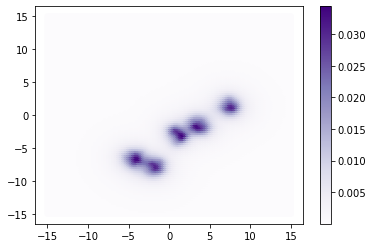

In [10]:

# Compute density with Bayesian nearest neighbors
k=60 ####
nbrs = KNeighborsDensity('bayesian',n_neighbors=k) ####
nbrs.fit(X) ####
dens_nbrs = nbrs.eval(Xgrid) / N

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs, cmap="Purples", edgecolor="None")
plt.colorbar()


Now do a Gaussian mixture model. Do a grid search for between 1 and 10 components.


1


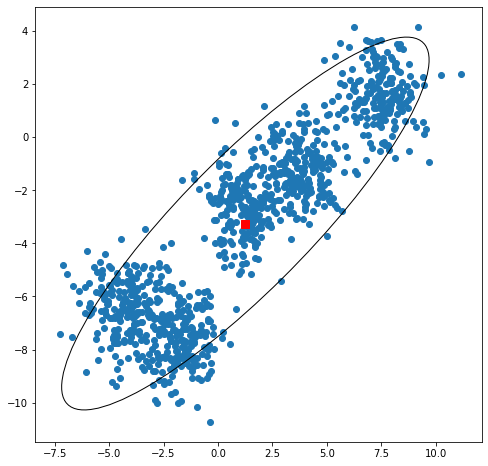

In [16]:

#Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

                             
ncomps = np.arange(1,10,10) # Test 10 bandwidths from 1 to 10 ####
K = 5 # 5-fold cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': ncomps}, cv=K)  ####
grid.fit(X) #Fit the histogram data that we started the lecture with.
ncomp_opt = grid.best_params_['n_components'] ####
print(ncomp_opt)

gmm = GaussianMixture(n_components=ncomp_opt) ####
gmm.fit(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(X[:,0],X[:,1])

ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='s', c='red', s=80)
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(mu, 1*C, scales=[2], ax=ax, fc='none', ec='k') #2 sigma ellipses for each component

Do you get the same answer (the same number of components) each time you run it?
Why is that the case?

Yes, I get that one component is the best parameter. I am not sure why that is the case give that there are 2 very clear clusters and 3 moderately clear clusters at leaset. I would expect that the GMM would pick up on that. However, I am not sure what method is used to determine the best parameter and maybe it weights heavily towards the most simple solution.

Now try Kmeans. Here we will scale the data.


Text(0.5, 1.0, 'Truth')

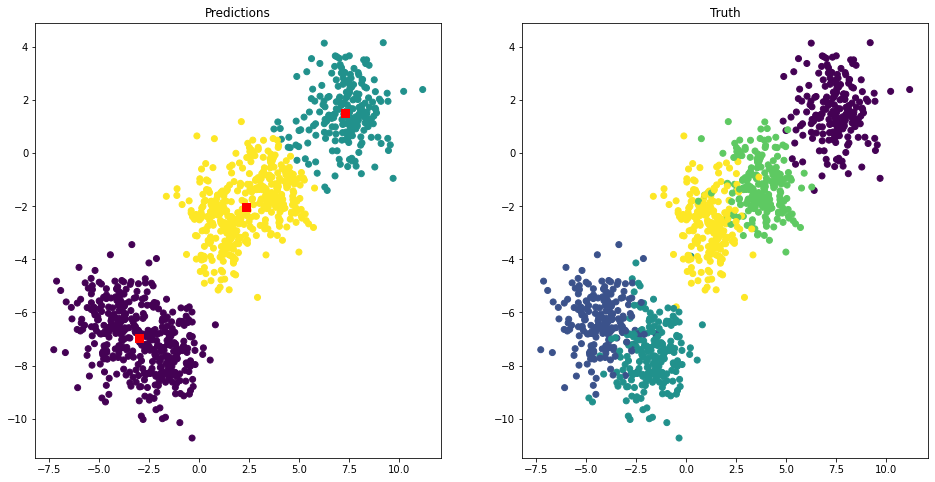

In [27]:

kmeans = KMeans(n_clusters=3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) ####
kmeans.fit(X_scaled)
centers=kmeans.cluster_centers_ #location of the clusters ####
labels=kmeans.predict(X_scaled) #labels for each of the points ####
centers_unscaled = scaler.inverse_transform(centers) ####


fig,ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].scatter(X[:,0],X[:,1],c=labels)
ax[0].scatter(centers_unscaled[:,0], centers_unscaled[:,1], marker='s', c='red', s=80)
ax[0].set_title("Predictions")

ax[1].scatter(X[:, 0], X[:, 1], c=y)
ax[1].set_title("Truth")



Let's evaluate how well we did in two other ways: a matrix and a score.


In [26]:
print("this is still 5")
df = pd.DataFrame({'predictions': labels, 'truth': y})
ct = pd.crosstab(df['predictions'], df['truth'])
print(ct)

from sklearn.metrics.cluster import homogeneity_score
score = homogeneity_score(df['truth'], df['predictions'])
print(score)


this is still 5
truth          0    1    2    3    4
predictions                         
0              0    0    1   11  185
1            194    0    0    1    0
2              0  184   14    0    0
3              0   16  185    0    1
4              6    0    0  188   14
0.8473360929533547


In [28]:
print("this is with 3 clusters")
df = pd.DataFrame({'predictions': labels, 'truth': y})
ct = pd.crosstab(df['predictions'], df['truth'])
print(ct)

from sklearn.metrics.cluster import homogeneity_score
score = homogeneity_score(df['truth'], df['predictions'])
print(score)

this is with 3 clusters
truth          0    1    2    3    4
predictions                         
0              0  200  199    0    1
1            200    0    0   13    0
2              0    0    1  187  199
0.6229568833968279






What is the score for 3 clusters?


The score for 3 clusters is 0.6229568833968279 which is lower and thus worse than the score of 0.8473360929533547 with 5 clusters.